# **Healthcare Data Engine (HDE) v2 Starter Notebook**

### [**Important : To utilize HDEv2 functionality, a Google Cloud project must be allowlisted for HDEv2 access.**](https://docs.google.com/forms/d/e/1FAIpQLScm0CPKzBcI9qYul3ZJrcqKc-pNnqcU8Q8XBVZg8t1FH2bnsw/viewform?resourcekey=0-q7zFVJdOnI3n0FGrSPA1JQ)

###**Overview**

**Healthcare Data Engine** is a FHIR-based data platform with APIs and tools to help healthcare organizations transition their healthcare data to the Fast Healthcare Interoperability Resources (FHIR) standard.

Healthcare Data Engine provides the following benefits:

*   You can harmonize healthcare information collected from multiple, disparate systems into a single, patient-centric longitudinal patient record.
By harmonizing your source data to FHIR, you can make data analysis simpler and faster.
*   You can scale your healthcare system from on-premises to Google Cloud with built-in support for healthcare security and data privacy.

### **Objective**

The steps performed include:
- Create Healthcare Dataset and FHIR store using Cloud Healthcare API
- Enable Harmonization instance
- Create and run whistle harmonization and reconciliation pipeline jobs.
- Ingest sample patient FHIR resource to source FHIR store.
- View harmonized output in FHIR store.
- Manage HDEv2 Pipelines.
- Import FHIR resources from GCS to FHIR store.
- Clean up.

### **Before You Begin**






1.   [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.
2.   [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

2.   [Make sure your project is allowlisted for HDEv2 Access](https://docs.google.com/forms/d/e/1FAIpQLScm0CPKzBcI9qYul3ZJrcqKc-pNnqcU8Q8XBVZg8t1FH2bnsw/viewform?resourcekey=0-q7zFVJdOnI3n0FGrSPA1JQ)

4.   [Enable the Cloud Healthcare API](https://console.cloud.google.com/flows/enableapi?apiid=healthcare.googleapis.com).


<p>
Both you and the <a href="https://cloud.google.com/healthcare-api/docs/permissions-healthcare-api-gcp-products#the_cloud_healthcare_service_agent">Cloud Healthcare Service Agent</a> service account require certain permissions to run this Notebook.
</p>

```
Note: If you created a Google Cloud project for this tutorial, then, as the project creator, you're automatically granted the Owner (<code>roles/owner</code>) IAM role, which has the permissions. You don't need to be granted any additional IAM roles, but you must still grant the required roles to the <b>Cloud Healthcare Service Agent</b> service account.
```

<p>To get the permissions that you need to complete this tutorial, grant the following IAM roles. For instructions on granting roles, see <a href="/iam/docs/granting-changing-revoking-access">Manage access</a> or <a href="/healthcare-api/docs/controlling-access#using_cloud_iam_with_datasets">Control access to Cloud Healthcare API resources</a>. You might also be able to get the required permissions through <a href="/iam/docs/creating-custom-roles">custom roles</a> or other <a href="/iam/docs/understanding-roles">predefined roles</a>.</p>
<ul>
  <li>To create Cloud Healthcare API datasets: <a href="/healthcare-api/docs/access-control#healthcare.datasetAdmin">Healthcare Dataset Administrator (<code>roles/healthcare.datasetAdmin</code>)</a> on your Google Cloud project.</li>
  <li>To enable harmonization instances: <a href="/healthcare-api/private/healthcare-data-engine/docs/access-control#healthcare.harmonizationAdmin">Harmonization Instance Admin (<code>roles/healthcare.harmonizationAdmin</code>)</a> on the dataset where you're enabling the harmonization instance.</li>
  <li>To create Cloud Storage buckets: <a href="/iam/docs/understanding-roles#storage.admin">Storage Admin (<code>roles/storage.admin</code>)</a> on your Google Cloud project.</li>
  <li>To create, view, and delete mapping and reconciliation pipeline jobs: <a href="/healthcare-api/private/healthcare-data-engine/docs/access-control#healthcare.pipelineJobsAdmin">Healthcare Pipeline Job Administrator (<code>roles/healthcare.pipelineJobsAdmin</code>)</a> on the dataset where the harmonization instance is enabled.</li>
</ul>
<p>To get the permissions that the <b>Cloud Healthcare Service Agent</b> service account needs to complete this tutorial, ask your administrator to grant the service account the following Identity and Access Management roles:</p>
<ul>
<li>To read Whistle mappings from Cloud Storage: <a href="/iam/docs/understanding-roles#storage.objectViewer">Storage Object Viewer (<code>roles/storage.objectViewer</code>)</a>. For instructions, see <a href="/healthcare-api/private/healthcare-data-engine/docs/google-cloud-permissions#read-mappings">Read whistle mappings from Cloud Storage</a>.</li>
<li>To automatically create the harmonized FHIR store when enabling a harmonization instance: <a href="/healthcare-api/docs/access-control#healthcare.fhirStoreAdmin">Healthcare FHIR Store Administrator (<code>roles/healthcare.fhirStoreAdmin</code>)</a>. For instructions, see <a href="/healthcare-api/private/healthcare-data-engine/docs/google-cloud-permissions#harmonization-instance">Harmonization instance FHIR store permissions</a>.</li>
<li>To read from the Cloud Healthcare API source FHIR store: <a href="/healthcare-api/docs/access-control#healthcare.fhirStoreAdmin">Healthcare FHIR Store Administrator (<code>roles/healthcare.fhirStoreAdmin</code>)</a> on the source FHIR store.</li>
<li>To write FHIR resources to the harmonized FHIR store: <a href="/healthcare-api/docs/access-control#healthcare.fhirResourceEditor">Healthcare FHIR Resource Editor (<code>roles/healthcare.fhirResourceEditor</code>)</a> on the harmonized FHIR store.</li>
</ul>
</li>
</ol>


### **Authenticate your Google Cloud account**


In [1]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

### **Important variables to run this notebook**


**Setup Project and Location of Healthcare Dataset**

In [2]:
# Press SHIFT+ENTER to run the code cell and store its value

# Enter the PROJECT ID
PROJECT_ID = "hcls-managed-services-test"                 #@param

# Enter the REGION
REGION = "us-central1"                                    #@param

**Setup Healthcare API Dataset and FHIR store variables**

In [3]:
# Press SHIFT+ENTER to run the code cell and store its value

# Enter the HEALTHCARE API DATASET name
HEALTHCARE_DATASET_NAME = "test-hdev2"                     #@param

# Enter the SOURCE FHIR STORE NAME
SOURCE_FHIR_STORE = "fhir-streaming-source"         #@param

# Enter the source FHIR_STORE_VERSION e.g. 'STU3', 'R4'
FHIR_STORE_VERSION = "STU3"                               #@param

**Setup Cloud Storage bucket name to upload/store whistle mappings/code**

In [4]:
# Press SHIFT+ENTER to run the code cell and store its value

# Enter the GCS BUCKET NAME for whistle source code e.g. "whistle-bucket-hdev2"
SOURCE_CODE_GCS_BUCKET_NAME = "whistle-bucket-hdev2-new"           #@param

**Setup Mapping and reconciliation pipeline names**

In [5]:
# Press SHIFT+ENTER to run the code cell and store its value

# Enter the mapping pipeline name
MAPPING_PIPELINE_NAME = "map-patient-pipeline-new"            #@param

# Enter the recon pipeline name
RECON_PIPELINE_NAME = "recon-pipeline-new"                    #@param

### DO NOT MODIFY FOLLOWING VALUES UNLESS REQUIRED

In [15]:
GITHUB_URL = "https://github.com/ajitsonawane1/healthcare-data-harmonization.git"
RECON_PIPELINE_PAYLOAD =   "/content/healthcare-data-harmonization/notebooks/HDEv2_starter_notebook/recon_pipeline_payload.json"
MAPPING_PIPELINE_PAYLOAD = "/content/healthcare-data-harmonization/notebooks/HDEv2_starter_notebook/mapping_pipeline_payload.json"
FHIR_PATIENT_RESOURCE_PAYLOAD = "/content/healthcare-data-harmonization/notebooks/HDEv2_starter_notebook/fhir_stu3_patient_payload.json"

###**Step 1: Create a Cloud Healthcare API dataset**


In [6]:
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [7]:
!gcloud healthcare datasets create {HEALTHCARE_DATASET_NAME} \
  --project={PROJECT_ID} \
  --location={REGION}

ERROR: (gcloud.healthcare.datasets.create) ALREADY_EXISTS: already exists


####[Delete Cloud Healthcare API Dataset](#scrollTo=cY8LaKzoC7eN)

###**Step 2: Enable a harmonization instance**

In [8]:
!curl -X POST \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    -H "Content-Type: application/json; charset=utf-8" \
    -d "" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/harmonizationInstance:enable"

{
  "error": {
    "code": 400,
    "message": "Harmonization instance must be in DISABLED state in order to be enabled, existing instance is in state: ENABLED",
    "status": "FAILED_PRECONDITION"
  }
}


####[Disable Harmonization Instance](#scrollTo=WZUGhhR4A8JS)

### **Step 3: Create the source STU3 FHIR store**

In [9]:
!gcloud healthcare fhir-stores create {SOURCE_FHIR_STORE} \
  --project={PROJECT_ID} \
  --dataset={HEALTHCARE_DATASET_NAME} \
  --location={REGION} \
  --version={FHIR_STORE_VERSION}

ERROR: (gcloud.healthcare.fhir-stores.create) ALREADY_EXISTS: already exists


####[Delete Source FHIR Store](#scrollTo=RrGcljmGAWk1)

### **Step 4: Create a Source cloud storage bucket for whistle code**

In [ ]:
!gcloud storage buckets create gs://{SOURCE_CODE_GCS_BUCKET_NAME}

Creating gs://whistle-bucket-hdev2-new/...


####[Delete Cloud Storage bucket for whistle](#scrollTo=4Frzz_LZJBqf&line=1&uniqifier=1)

### **Step 5: Clone, Modify and Upload whistle mappings**

#### Step 5.1: Clone open source Starter Whistle mappings from github

In [13]:
!git clone {GITHUB_URL}

Cloning into 'healthcare-data-harmonization'...
remote: Enumerating objects: 6345, done.
remote: Counting objects: 100% (6345/6345), done.
remote: Compressing objects: 100% (2411/2411), done.
remote: Total 6345 (delta 3388), reused 6222 (delta 3347), pack-reused 0
Receiving objects: 100% (6345/6345), 17.15 MiB | 28.01 MiB/s, done.
Resolving deltas: 100% (3388/3388), done.


#### Step 5.2: Modify the Starter whistle mappings

If the folder does not appear within your notebook files section, try refreshing the files view.

**Adding the following import statement in your file `healthcare-data-harmonization/mappings/fhirVersionConversion/fhir_harmonization_r3r4.wstl` file**

`import "./../utilities/reconciliation/matching.wstl"`

In [ ]:
!sed '2iimport "./../utilities/reconciliation/matching.wstl"' /content/healthcare-data-harmonization/mappings/fhirVersionConversion/fhir_harmonization_r3r4.wstl

import "./mappings/r3r4/fhir_r3r4.wstl"
import "./../utilities/reconciliation/matching.wstl"

resources[]: callPackageFn("fhir_r3r4", "R3{$root.resourceType}ToR4", $root)


Check if import statement added correctly to the entrypoint file `fhir_harmonization_r3r4.wstl` file as shown in the image

#### 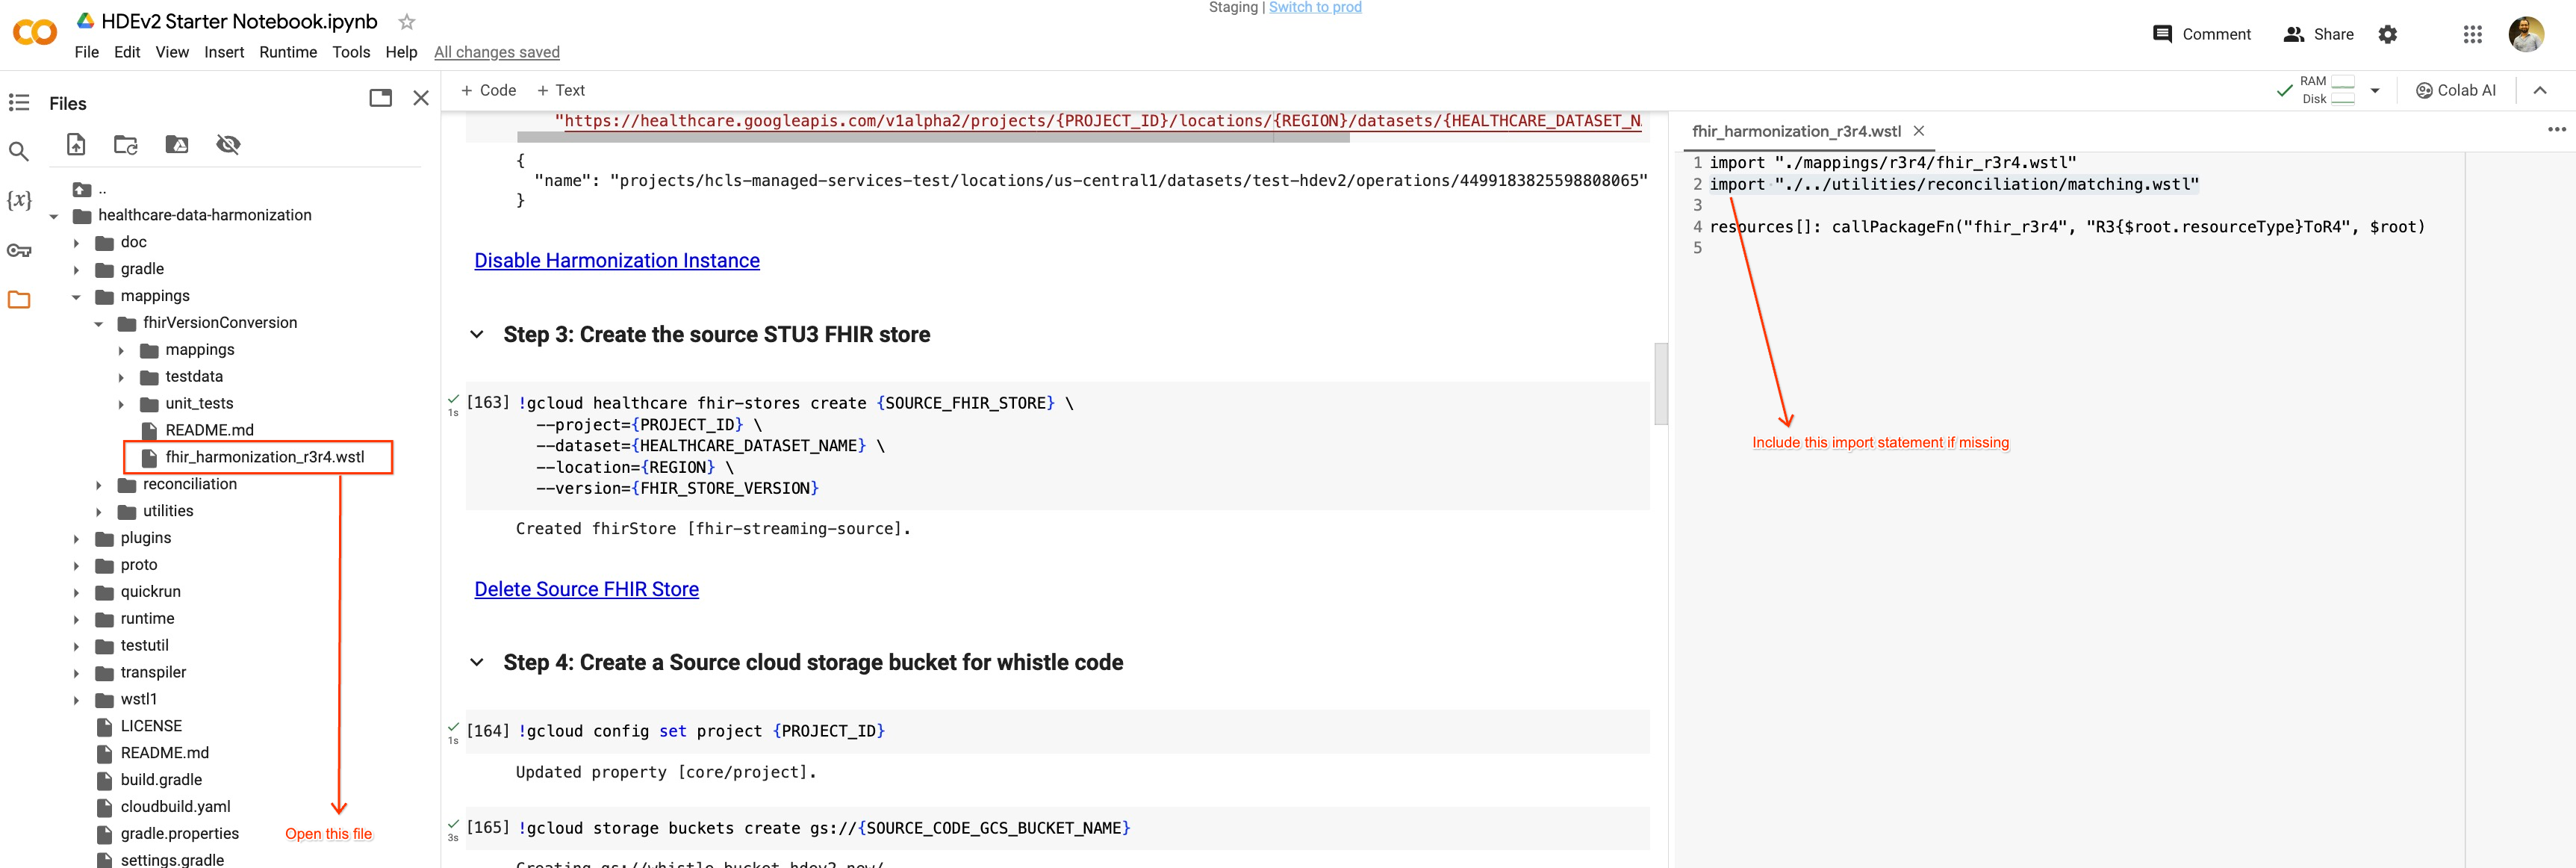

#### Step 5.3: **Upload** the code to the Source Code GCS bucket

In [ ]:
!gcloud storage cp -r healthcare-data-harmonization/mappings gs://{SOURCE_CODE_GCS_BUCKET_NAME}/

Copying file://healthcare-data-harmonization/mappings/reconciliation/unit_tests/test_matching.wstl to gs://whistle-bucket-hdev2-new/mappings/reconciliation/unit_tests/test_matching.wstl
Copying file://healthcare-data-harmonization/mappings/reconciliation/unit_tests/unit_test.wstl to gs://whistle-bucket-hdev2-new/mappings/reconciliation/unit_tests/unit_test.wstl
Copying file://healthcare-data-harmonization/mappings/reconciliation/unit_tests/test_merge.wstl to gs://whistle-bucket-hdev2-new/mappings/reconciliation/unit_tests/test_merge.wstl
Copying file://healthcare-data-harmonization/mappings/reconciliation/unit_tests/merge/Procedure_from_ir.output.json to gs://whistle-bucket-hdev2-new/mappings/reconciliation/unit_tests/merge/Procedure_from_ir.output.json
Copying file://healthcare-data-harmonization/mappings/reconciliation/unit_tests/merge/AllergyIntolerance_from_ir.input.json to gs://whistle-bucket-hdev2-new/mappings/reconciliation/unit_tests/merge/AllergyIntolerance_from_ir.input.json


### **Step 6: Create and run the Whistle reconciliation pipeline**

In [16]:
# Replacing the source code gcs bucket name
! sed -i 's/REPLACE-SOURCE-BUCKET-NAME/{SOURCE_CODE_GCS_BUCKET_NAME}/'  {RECON_PIPELINE_PAYLOAD}

In [17]:
# Replacing the recon pipeline name
! sed -i 's/REPLACE-RECON-PIPELINE-NAME/{RECON_PIPELINE_NAME}/'       {RECON_PIPELINE_PAYLOAD}

In [18]:
!cat {RECON_PIPELINE_PAYLOAD}
confirmation = input("\n Does the payload values look correct for recon pipeline? , please press Y/y if yes : ")
if confirmation.lower() == "y":
  pass
else:
  print("Please change the payload values for recon pipeline before executing the next cell")

{
    "name": "recon-pipeline-new",
    "reconciliationPipelineJob": {
        "mergeConfig": {
            "whistleConfigSource": {
                "uri": "gs://whistle-bucket-hdev2-new/mappings/utilities/reconciliation/merge.wstl",
                "importUriPrefix": "gs://whistle-bucket-hdev2-new/mappings/utilities/reconciliation/"
            }
        }
    }
}
 Does the payload values look correct for recon pipeline? , please press Y/y if yes : y


In [19]:
## Please change payload values

!curl -X POST \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    -H "Content-Type: application/json; charset=utf-8" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/pipelineJobs?pipelineJobId={RECON_PIPELINE_NAME}"   \
    -d @{RECON_PIPELINE_PAYLOAD}

{
  "error": {
    "code": 409,
    "message": "already exists",
    "status": "ALREADY_EXISTS"
  }
}


####[Cancel Pipeline Job](#scrollTo=3h26WBkJHk_L)

####[Delete Pipeline Job](#scrollTo=qnlKm9f2Hngq)

### **Step 7: Create and run the Whistle mapping pipeline**

In [20]:
# Replacing the source code gcs bucket name
! sed -i 's/REPLACE-SOURCE-BUCKET-NAME/{SOURCE_CODE_GCS_BUCKET_NAME}/' {MAPPING_PIPELINE_PAYLOAD}

# Replacing the mapping pipeline name
! sed -i 's/REPLACE-MAPPING-PIPELINE-NAME/{MAPPING_PIPELINE_NAME}/'       {MAPPING_PIPELINE_PAYLOAD}

# Replacing FHIR STORE url values
! sed -i 's/REPLACE-PROJECT-NAME/{PROJECT_ID}/'       {MAPPING_PIPELINE_PAYLOAD}
! sed -i 's/REPLACE-REGION/{REGION}/'       {MAPPING_PIPELINE_PAYLOAD}
! sed -i 's/REPLACE-DATASET-NAME/{HEALTHCARE_DATASET_NAME}/'       {MAPPING_PIPELINE_PAYLOAD}
! sed -i 's/REPLACE-FHIR-STORE-NAME/{SOURCE_FHIR_STORE}/'       {MAPPING_PIPELINE_PAYLOAD}

In [21]:
!cat {MAPPING_PIPELINE_PAYLOAD}
confirmation = input("\n Does the payload values look correct for mapping pipeline? , please press Y/y if yes : ")
if confirmation.lower() == "y":
  pass
else:
  print("Please change the payload values for mapping pipeline before executing the next cell")

{
    "name": "map-patient-pipeline-new",
    "mappingPipelineJob": {
      "mappingConfig": {
        "whistleConfigSource": {
          "uri": "gs://whistle-bucket-hdev2-new/mappings/fhirVersionConversion/fhir_harmonization_r3r4.wstl",
          "importUriPrefix": "gs://whistle-bucket-hdev2-new/mappings/"
        }
      },
      "fhirStreamingSource": {
        "fhirStore": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/fhir-streaming-source"
      }
    }
  }
 Does the payload values look correct for mapping pipeline? , please press Y/y if yes : y


In [22]:
!curl -X POST \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    -H "Content-Type: application/json; charset=utf-8" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/pipelineJobs?pipelineJobId={MAPPING_PIPELINE_NAME}" \
    -d @{MAPPING_PIPELINE_PAYLOAD}

{
  "error": {
    "code": 409,
    "message": "already exists",
    "status": "ALREADY_EXISTS"
  }
}


####[Cancel Pipeline Job](#scrollTo=3h26WBkJHk_L)

####[Delete Pipeline Job](#scrollTo=qnlKm9f2Hngq)

### **Step 8: Ingest a FHIR STU3 Patient resource**

####[Check Pipeline job state before ingesting FHIR resources to the FHIR store](#scrollTo=EYSECdkFDok1)

#### Ingest sample patient resource to Source streaming FHIR store

In [23]:
!curl -X POST \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    -H "Content-Type: application/fhir+json" \
    -d @{FHIR_PATIENT_RESOURCE_PAYLOAD} \
    "https://healthcare.googleapis.com/v1/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/fhirStores/{SOURCE_FHIR_STORE}/fhir/Patient"

{
  "active": true,
  "address": [
    {
      "city": "Mountain View",
      "line": [
        "1800 Amphibious Blvd."
      ],
      "period": {
        "start": "1970-01-01"
      },
      "postalCode": "94045",
      "state": "California",
      "text": "1800 Amphibious Blvd. Mountain View, California 94045",
      "type": "both",
      "use": "home"
    }
  ],
  "birthDate": "1970-01-01",
  "deceasedBoolean": false,
  "gender": "female",
  "id": "ac7539bb-57fc-4242-ab11-4e43bc56f814",
  "identifier": [
    {
      "assigner": {
        "display": "Google"
      },
      "period": {
        "start": "2001-05-06"
      },
      "system": "urn:oid:1.2.36.146.595.217.0.1",
      "type": {
        "coding": [
          {
            "code": "MR",
            "system": "http://terminology.hl7.org/CodeSystem/v2-0203"
          }
        ]
      },
      "use": "usual",
      "value": "12345"
    }
  ],
  "maritalStatus": {
    "coding": [
      {
        "code": "U",
        "display": "

####[Import FHIR resources from GCS to Source FHIR store](#scrollTo=fhewmQ0sxdf0)

### **Step 9: View the harmonized FHIR R4 Patient resource**

In [ ]:
!curl -X GET \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    "https://healthcare.googleapis.com/v1/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/fhirStores/harmonized-fhir-store/fhir/Patient"

{
  "entry": [
    {
      "fullUrl": "https://healthcare.googleapis.com/v1/projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/harmonized-fhir-store/fhir/Patient/f5d1c99e-1151-471c-9c47-febc3fcce935",
      "resource": {
        "active": true,
        "address": [
          {
            "city": "Mountain View",
            "line": [
              "1800 Amphibious Blvd."
            ],
            "period": {
              "start": "1970-01-01"
            },
            "postalCode": "94045",
            "state": "California",
            "text": "1800 Amphibious Blvd. Mountain View, California 94045",
            "type": "both",
            "use": "home"
          }
        ],
        "birthDate": "1970-01-01",
        "deceasedBoolean": false,
        "gender": "female",
        "id": "f5d1c99e-1151-471c-9c47-febc3fcce935",
        "identifier": [
          {
            "assigner": {
              "display": "Google"
            },
           

###**Step 10: Get lineage info of Source and/or Harmonized resource**

In [ ]:
# SOURCE_FHIR_RESOURCE: A reference to the resource in the source FHIR store, in the format:
# projects/{projectId}/locations/{locationId}/datasets/{datasetId}/fhirStores/{fhirstore_id}/fhir/{resourceType}/{resourceId}
# If the suffix of the resource name is _history/{version_id}, lineage details
# are returned for the specified version of the resource in the source FHIR store.

SOURCE_FHIR_RESOURCE = "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/fhir-streaming-source/fhir/Patient/4901ca5e-2793-445f-b4e8-30782767e223"

In [ ]:
!curl -X GET \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/harmonizationInstance:lineage?fhirSource={SOURCE_FHIR_RESOURCE}"

{
  "lineageEntries": [
    {
      "harmonizationSteps": [
        {
          "pipelineJob": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/map-patient-pipeline-new@f43e3c1f",
          "source": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/fhir-streaming-source/fhir/Patient/4901ca5e-2793-445f-b4e8-30782767e223/_history/MTcwNjE5MDYyMDkyMzUwNDAwMA",
          "target": {
            "operation": "WRITE",
            "mappedSnapshotId": "Patient/462efbb0-295d-3a8b-a7ef-0c9112567e40"
          },
          "commitTime": "2024-01-25T13:51:33.547835Z"
        },
        {
          "pipelineJob": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/recon-pipeline-new@e9ac37ea",
          "source": "Patient/462efbb0-295d-3a8b-a7ef-0c9112567e40",
          "target": {
            "operation": "WRITE",
            "harmonizedResource": "projects/hcls-managed-servic

In [ ]:
# HARMONIZED_FHIR_RESOURCE: Reference to the harmonized FHIR store resource.
# For example, projects/{projectId}/locations/{locationId}/datasets/{datasetId}/fhirStores/{fhirstore_id}/fhir/{resourceType}/{resourceId}
# If the suffix of the resource name is _history/{version_id}, lineage details
# are returned for the specified version of the resource in the harmonized FHIR store.

HARMONIZED_FHIR_RESOURCE = "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/harmonized-fhir-store/fhir/Patient/f5d1c99e-1151-471c-9c47-febc3fcce935"

In [ ]:
!curl -X GET \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/harmonizationInstance:lineage?harmonizedResource={HARMONIZED_FHIR_RESOURCE}"

{
  "lineageEntries": [
    {
      "harmonizationSteps": [
        {
          "pipelineJob": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/map-patient-pipeline-new@f43e3c1f",
          "source": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/fhir-streaming-source/fhir/Patient/4901ca5e-2793-445f-b4e8-30782767e223/_history/MTcwNjE5MDYyMDkyMzUwNDAwMA",
          "target": {
            "operation": "WRITE",
            "mappedSnapshotId": "Patient/462efbb0-295d-3a8b-a7ef-0c9112567e40"
          },
          "commitTime": "2024-01-25T13:51:33.547835Z"
        },
        {
          "pipelineJob": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/recon-pipeline-new@e9ac37ea",
          "source": "Patient/462efbb0-295d-3a8b-a7ef-0c9112567e40",
          "target": {
            "operation": "WRITE",
            "harmonizedResource": "projects/hcls-managed-servic

## **Manage Pipeline Jobs**



---



### **Get Reconciliation pipeline job details**

In [ ]:
!curl -X GET \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/pipelineJobs/{RECON_PIPELINE_NAME}"

{
  "name": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/recon-pipeline-new",
  "revisionId": "518ec24b",
  "state": "PIPELINE_RUNNING",
  "metrics": {},
  "revisionCreateTime": "2024-01-23T05:58:46.347478Z",
  "reconciliationPipelineJob": {
    "mergeConfig": {
      "whistleConfigSource": {
        "uri": "gs://whistle-bucket-hdev2/whistle_quickstart/utilities/reconciliation/merge.wstl",
        "importUriPrefix": "gs://whistle-bucket-hdev2/whistle_quickstart/utilities/reconciliation/"
      }
    }
  }
}


### **Get Mapping pipeline job details**

In [ ]:
!curl -X GET \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/pipelineJobs/{MAPPING_PIPELINE_NAME}"

{
  "name": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/map-patient-pipeline-new",
  "revisionId": "98539629",
  "state": "PIPELINE_RUNNING",
  "metrics": {},
  "revisionCreateTime": "2024-01-23T05:59:20.249312Z",
  "mappingPipelineJob": {
    "mappingConfig": {
      "whistleConfigSource": {
        "uri": "gs://whistle-bucket-hdev2/whistle_quickstart/fhir_harmonization_r3_r4.wstl",
        "importUriPrefix": "gs://whistle-bucket-hdev2/whistle_quickstart/"
      }
    },
    "fhirStreamingSource": {
      "fhirStore": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/fhir-streaming-source"
    }
  }
}


### **List Mapping And/Or Reconciliation pipeline Jobs**

In [ ]:
!curl -X GET \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/pipelineJobs"

{
  "pipelineJobs": [
    {
      "name": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/recon-pipeline-new",
      "revisionId": "e9ac37ea",
      "state": "PIPELINE_RUNNING",
      "revisionCreateTime": "2024-01-25T13:36:33.990611Z",
      "reconciliationPipelineJob": {
        "mergeConfig": {
          "whistleConfigSource": {
            "uri": "gs://whistle-bucket-hdev2-new/mappings/utilities/reconciliation/merge.wstl",
            "importUriPrefix": "gs://whistle-bucket-hdev2-new/mappings/utilities/reconciliation/"
          }
        }
      }
    },
    {
      "name": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/map-patient-pipeline-new",
      "revisionId": "f43e3c1f",
      "state": "PIPELINE_RUNNING",
      "revisionCreateTime": "2024-01-25T13:37:02.418948Z",
      "mappingPipelineJob": {
        "mappingConfig": {
          "whistleConfigSource": {
            "uri": "gs://whistle-

### **List pipeline job revisions**

In [ ]:
# Enter Pipeline job id/name to list revisions
PIPELINE_NAME = "map-patient-pipeline-new"

In [ ]:
!curl -X GET \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/pipelineJobs/{PIPELINE_NAME}:listRevisions"

{
  "pipelineJobs": [
    {
      "name": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/map-patient-pipeline-new",
      "revisionId": "98539629",
      "state": "PIPELINE_RUNNING",
      "revisionCreateTime": "2024-01-23T05:59:20.249312Z",
      "mappingPipelineJob": {
        "mappingConfig": {
          "whistleConfigSource": {
            "uri": "gs://whistle-bucket-hdev2/whistle_quickstart/fhir_harmonization_r3_r4.wstl",
            "importUriPrefix": "gs://whistle-bucket-hdev2/whistle_quickstart/"
          }
        },
        "fhirStreamingSource": {
          "fhirStore": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/fhir-streaming-source"
        }
      }
    }
  ]
}


### **Get pipeline job details by revision**

In [ ]:
# Provide revision ID of pipeline job. You can get revision_id from the output of above cell.
REVISION_ID = "98539629"

In [ ]:
!curl -X GET \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/pipelineJobs/{PIPELINE_NAME}@{REVISION_ID}"

{
  "name": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/pipelineJobs/map-patient-pipeline-new@98539629",
  "revisionId": "98539629",
  "state": "PIPELINE_RUNNING",
  "metrics": {},
  "revisionCreateTime": "2024-01-23T05:59:20.249312Z",
  "mappingPipelineJob": {
    "mappingConfig": {
      "whistleConfigSource": {
        "uri": "gs://whistle-bucket-hdev2/whistle_quickstart/fhir_harmonization_r3_r4.wstl",
        "importUriPrefix": "gs://whistle-bucket-hdev2/whistle_quickstart/"
      }
    },
    "fhirStreamingSource": {
      "fhirStore": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/fhir-streaming-source"
    }
  }
}


### **Cancel pipeline job**

In [ ]:
# Enter pipeline job name/id
PIPELINE_JOB_ID = "recon-pipeline-new"

In [ ]:

!curl -X POST \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    -H "Content-Type: application/json; charset=utf-8" \
    -d "" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/pipelineJobs/{PIPELINE_JOB_ID}:cancel"

{}


### **Delete pipeline job**

In [ ]:
# Enter pipeline job name/id
PIPELINE_JOB_ID = "recon-pipeline-new"

In [ ]:
!curl -X DELETE \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/pipelineJobs/{PIPELINE_JOB_ID}"

{}




---



# **FHIR Store Operations**



---



### **Importing FHIR Resources from GCS to Source FHIR Store**

In [ ]:
# Enter GCS path of source .ndjson file e.g. 'gs://BUCKET/DIRECTORY/FHIR_RESOURCE_NAME.ndjson'
GCS_URI = "gs://hdev2-whistle-mappings/Patient.ndjson"

In [ ]:
!gcloud healthcare fhir-stores import gcs {SOURCE_FHIR_STORE} \
  --dataset={HEALTHCARE_DATASET_NAME} \
  --location={REGION} \
  --gcs-uri={GCS_URI} \
  --content-structure=RESOURCE

Request issued for: [fhir-streaming-source]
name: projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/fhirStores/fhir-streaming-source
version: STU3




---



# **Clean Up Resources**



---



### Delete Source FHIR Store

In [ ]:

!gcloud healthcare fhir-stores delete {SOURCE_FHIR_STORE} \
  --dataset={HEALTHCARE_DATASET_NAME} \
  --location={REGION}

You are about to delete fhirStore [fhir-streaming-source]

Do you want to continue (Y/n)?  Y

Deleted fhirStore [fhir-streaming-source].


### Disable Harmonization Instance

Disabling a harmonization instance has the following effects:

1. Deletes all mapping and reconciliation pipelines, regardless of their state.
2. Deletes all data related to the harmonization instance, such as lineage and reconciliation data.

Disabling a harmonization instance doesn't modify or delete the harmonized FHIR store.



In [ ]:
!curl -X POST \
    -H "Authorization: Bearer $(gcloud auth print-access-token)" \
    -H "Content-Type: application/json; charset=utf-8" \
    -d "" \
    "https://healthcare.googleapis.com/v1alpha2/projects/{PROJECT_ID}/locations/{REGION}/datasets/{HEALTHCARE_DATASET_NAME}/harmonizationInstance:disable"

{
  "name": "projects/hcls-managed-services-test/locations/us-central1/datasets/test-hdev2/operations/16320851784786509825"
}


### Delete Healthcare Dataset

In [ ]:
!gcloud healthcare datasets delete {HEALTHCARE_DATASET_NAME} \
  --location={REGION}

You are about to delete dataset [test-hdev2]

Do you want to continue (Y/n)?  Y

Deleted dataset [test-hdev2].


###Delete Cloud Storage bucket for whistle

In [ ]:
!gcloud storage rm --recursive gs://{SOURCE_CODE_GCS_BUCKET_NAME}/

Removing objects:
Removing gs://whistle-bucket-hdev2-new/mappings/fhirVersionConversion/README.md#1706182493294969...
Removing gs://whistle-bucket-hdev2-new/mappings/fhirVersionConversion/mappings/ResourceBase.wstl#1706182493258733...
Removing gs://whistle-bucket-hdev2-new/mappings/fhirVersionConversion/mappings/code_harmonization/Clinical_Impression_Status_r3r4.harmonization.json#1706182520969395...
Removing gs://whistle-bucket-hdev2-new/mappings/fhirVersionConversion/mappings/code_harmonization/Research_Study_Status_r3r4.harmonization.json#1706182520301481...
Removing gs://whistle-bucket-hdev2-new/mappings/fhirVersionConversion/mappings/datatypes/Signature.wstl#1706182495065093...
Removing gs://whistle-bucket-hdev2-new/mappings/fhirVersionConversion/mappings/datatypes/Uri.wstl#1706182493683702...
Removing gs://whistle-bucket-hdev2-new/mappings/fhirVersionConversion/mappings/r2r3/Appointment.wstl#1706182506364495...
Removing gs://whistle-bucket-hdev2-new/mappings/fhirVersionConversion